# Spervised Dimentionality Reduction


In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [3]:
#%pylab inline
import numpy
import pandas
import pylab

#sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

from sklearn.pipeline import Pipeline

#scipy
import scipy.linalg as alg

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# Load Iris data
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# load parkinsons data
data = pandas.read_csv('data/parkinsons.data.txt', sep=",", index_col='name')
y_pak = numpy.asarray(LabelEncoder().fit_transform(data['status']))
X_pak = data.drop('status', axis=1).values

# load wine data
data = pandas.read_csv('data/wine.data.txt', sep=",")
y_wine = numpy.asarray(LabelEncoder().fit_transform(data.iloc[:,0]))
X_wine = data.iloc[:, 1:].values

<h2>Data preprocessing, why?</h2>
<ul>
    <li><b>Problem: </b>Features with different dynamic ranges, results in features with large values having a larger influence in the classifier's cost function than features with small values.</li>
    <li><b>Solution: </b>Normalise features for best performance</li>
</ul>

<ul>
    <li><h3>Normalisation methods</h3></li>
<ul>
    <li><h4>Standardisation</h4></li>
    <ul>
        <li>Rescale features to have $\mu=0$ and $\sigma=1$</li>
        $$X_{new} = \frac{X-\mu}{\sigma}$$
        <li><b>N.B</b> Use the training data  $\mu$ and $\sigma$ to rescale the test and validation data</li>
    </ul>
</ul>
</ul>

<ul>
<ul>
    <li><h4>Rescaling</h4></li>
    <ul>
        <li>Rescale features to unit range</li>
        $$X_{new} = \frac{X-X_\min}{X_\max-X_\min}$$
    </ul>
</ul>
</ul>

<h2>Discriminant analysis</h2>
<ul>
    <li>Is a supervised method for dimentionality reduction</li>
    <li>The aim is to project data on to directions that are efficient for discrimination</li>
    <li>Examples are LDA and MDA/Canonical variates</li>
    <li>LDA is is a method used to find a linear combination of features that characterizes or separates two classes</li>
    <li>MDA is just LDA for multiclass problems</li>
    <li>MDA generalises to LDA when the number of classes is two</li>
</ul>

<h2>Discriminant analysis</h2>
<h3> LDA analysis algorithm steps:</h3>
<ol>
<li> Compute the mean vectors of each feature for each class in the data.</li>
<li>Compute the scatter matrices $\mathbf{S}_b$ and $\mathbf{S}_w$</li>
<li>Compute the eigenvectors $\mathbf{e_1, e_2, ..., e_d}$ and corresponding eigenvalues $\lambda_1, \lambda_2, ..., \lambda_3$ for the scatter matrices</li>
<li>Sort the eigenvectors in decreasing order of the eigenvalues</li>
<li>Choose $C-1$ eigenvectors with the largest eigenvalues to form a $d\times C-1$ dimensional matrix $W$</li>
<li>Apply $X_{new} = X\times W$ to get the dimentionality reduced data</li>
</ol>


<h2>Discriminant analysis</h2>
<h3> Scatter matrices</h3>
<ul>
    <li><h4>The within-class scatter ($\mathbf{S}_w$)</h4></li>
        <ul>
            <li>The within-class scatter $\mathbf{S}_w$ is defined by,
            $$\mathbf{S}_w = \sum_{i=1}^C \mathbf{S}_i$$ where
            $$\mathbf{S}_i = \sum_{\mathbf{x}\in D_i}(\mathbf{x}-\mu_i)(\mathbf{x}-\mu_i)^\top$$ which is the scatter matrix for every class and $\mu_i$ is the mean feature vector of class $i$  <a href="http://eu.wiley.com/WileyCDA/WileyTitle/productCd-0471056693.html"> Duda2001</a>. </li>
            <li>The trace $\texttt{Trace}\{\mathbf{S}_w\}$ measures the average, over all classes, variance of the feature.</li>
        </ul>
</ul>


<ul>
    <li><h4>The between-class scatter ($\mathbf{S}_b$)</h4></li>
        <ul>
            <li>The between-class scatter $\mathbf{S}_b$ is defined by,
            $$\mathbf{S}_b = \sum_{i=1}^C N_i(\mu_i-\mu)(\mu_i-\mu)^\top$$ where $\mu$ is the overall mean of the datatset, $\mu_i$ is the mean feature vector of class $i$ and $N_i$ is number of samples in class $i$ <a href="http://eu.wiley.com/WileyCDA/WileyTitle/productCd-0471056693.html"> Duda2001</a></li>
            <li>The trace $\texttt{Trace}\{\mathbf{S}_b\}$ measures the average (over all classes) distance of the mean of each individual class from the respective global value.</li>
</ul>

<h3> Scatter matrices</h3>
<ul>
    <li><h4>The mixture scatter matrix ($\mathbf{S}_m$)</h4>
    <ul>
        <li>The mixture scatter matrix $\mathbf{S}_m$ is given by,</li>
        $$\mathbf{S}_m = \mathbf{S}_w + \mathbf{S}_b$$
        <li>The trace $\texttt{Trace}\{\mathbf{S}_m\}$ is the sum of variances of the features around their respective global mean</li>
    </ul>
</ul>

In [12]:
def partition_data_per_classes(X, y):
    """Groups data based on class label
    
    Parameters
    ----------
    X : {array-like}, shape (n_samples, n_features)
        Data, where n_samples is the number of samples
        and n_features is the number of features.

    y: {array-like}, shape (n_samples, )
        Contains the target/classes for the training data X

    Returns
    -------
    x_sorted : dict of arrays with class label as keys    
    """
    x_sorted = dict()
    classes = numpy.unique(y)
    # Get class indices
    for lbl in classes:
        index, = numpy.where(y == lbl)
        x_sorted[lbl] = X[index, :]

    return x_sorted

In [13]:
def scatter_matrix(X, y, gamma=0.):
    """Calculate the scatter matrices
    
    Parameters
    ----------
    X : {array-like}, shape (n_samples, n_features)
        Data, where n_samples is the number of samples
        and n_features is the number of features.

    y: {array-like}, shape (n_samples, )
        Contains the target/classes for the training data X

    gamma: a float object, (Default: 0)
        Regularisation parameter
        
    Returns
    -------
    output: A tuple object, shape(2,)
        The within and between class scatter matrices 
    """
    classes = numpy.unique(y)
    n_samples, n_features = X.shape
    data = partition_data_per_classes(X=X, y=y)
    
    # Compute the feature mean for each class
    class_mean = numpy.zeros(shape=(len(classes), n_features), dtype='float32')
    for i, lbl in enumerate(classes):
        class_mean[i, :] = numpy.mean(data[lbl], axis=0)

    # Data mean
    data_mean = numpy.mean(class_mean, axis=0)

    # Calculate the within class scatter
    sw = numpy.zeros(shape=(n_features,), dtype='float32')
    diag = numpy.zeros(shape=(n_features,), dtype='float32')

    for i, lbl in enumerate(classes):
        centered_data = data[lbl] - class_mean[i]
        dot = numpy.dot(centered_data.T, centered_data)
        diag = diag + numpy.diag(numpy.diag(dot))
        sw = sw + data[lbl].shape[0] * dot

    # Within class scatter regularisation
    sw = (1 - gamma) * sw + diag

    # Calculate the between class scatter
    sb = numpy.zeros(shape=(n_features,), dtype='float32')
    diag = numpy.zeros(shape=(n_features,), dtype='float32')

    for i, lbl in enumerate(classes):
        centered_data = class_mean[i] - data_mean
        dot = numpy.outer(centered_data.T, centered_data)
        diag = diag + numpy.diag(numpy.diag(dot))
        sb = sb + data[lbl].shape[0] * dot

    # Between class scatter regularisation
    sb = (1 - gamma) * sb + diag
    
    return sw, sb

<h2>Discriminant analysis</h2>
<h3>Solving the eigen-value problem</h3>
<ul>
<li>LDA aims to find the projection matrix ${W}$, which maximises the ratio of the between-class scatter matrix to the within-class scatter matrix</li>
<li> ${W}$ is derived from the first $C-1$ or $\ell < d$  eigenvectors corresponding to the eigenvalues of the generalised eigenvalue problem $${S}_B{W} = \lambda{S}_w{W}$$ which is only possible if the scatter matrices are invertible.</li>

<li> Regularising the scatter matrices avoids the non-invertible matrix problem by adding a diagonal component to the scatter matrices <a href="http://eu.wiley.com/WileyCDA/WileyTitle/productCd-0471056693.html"> Duda2001</a></li> $${S'} = {S+D}$$ is the matrix resulting from regularization, where ${S}'$ is the the regularised matrix, ${S}$ is the original scatter matrix ${S}_w$ or ${S}_B$ and $\displaystyle{{D} = ({x}-\mu_i)({x}-\mu_i)^\top}$ in case ${S}_B$ and ${D} = (\mu-\mu_i)(\mu-\mu_i)^\top$ in case ${S}_w$.</li>

<li> A whitening transform can be applied to the between-class scatter matrix, in order to further maximise the distances between the class means as follows, $${S''}_B = {S'}_B {VDV}^\top$$
where, ${S''}_B$ is the whitened between-class scatter matrix, ${S'}_B$ is the regularised between-class scatter matrix, ${V}$ are the eigenvectors of ${S'}_B$, and ${D}$ is the diagonal elements of the eigenvalues of ${S'}_B $.</li> 

<li>Finally to obtain the optimum ${W}$ projection matrix, the eigenvalue problem can be solved by, $${S''}_B {W} = \lambda{S'}_w{W}$$</li>
</ul>

In [14]:
def lda_projection_matrix(sw, sb):
    """Compute LDA projection matrix from the scatter matrix
    
    Parameters
    ----------
    sw: {array-like}, shape (n_features, n_features)
        The within class scatter
        
    sb: {array-like}, shape (n_features, n_features)
        The between class scatter
    Returns
    -------
    output - {array-like}, shape(n_features, n_features)
        LDA projection matrix W
    """
    # Whiten the between-class scatter in order to further maximise 
    # the distances between the class means.
    lambda_, v = alg.eig(sb)
    order = numpy.argsort(lambda_)[::-1]
    lambda_ = lambda_[order]
    v = v[:, order]
    p = numpy.dot(numpy.dot(v, numpy.diag(lambda_)), v.T)
    sb = numpy.dot(sb, p)

    # Compute the projection matrix
    lambda_, V = alg.eig(sb, sw)
    order = numpy.argsort(lambda_)[::-1]
    W = V[:, order]

    return numpy.real(W)

<h2>Class separabiility</h2>
<ul>
    <li><h3>Fisher's discriminant ratio</h3></li>
        <ul>
            <li> Fisher’s discriminant ratio (`FDR`) is commonly employed to quantify the discriminatory power of individual features between two equiprobable classes.</li>
            <li> For the multi-class problem the $m$-th feature $FDR_m$ is given by, $$FDR_m=\sum_i^C\sum_{j\neq i}^C \frac{\left(\mu_i-\mu_j\right)^2}{\sigma_i+\sigma_j}$$where where $i, j$ refer to the mean and variance corresponding to the $m$-th feature classes $C_i, C_j$ respectively. </li>
            <li>Features having large differences between the means of the classes and small variances in each class, will have high FDR values</li>            
        </ul>
</ul>

In [15]:
def fdr(X, y):
    """Fisher discriminant ratio
    
    Parameters
    ----------
    X : {array-like}, shape (n_samples, n_features)
        Data, where n_samples is the number of samples
        and n_features is the number of features.

    y: {array-like}, shape (n_samples, )
        Contains the target/classes for the training data X

    Returns
    -------
    fdr : {array-like}, shape(n) with class label as keys    
    """
    classes = numpy.unique(y)
    n_samples, n_features = X.shape
    data = partition_data_per_classes(X=X, y=y)
    
    # Compute the feature mean and variance for each class
    class_means = numpy.zeros(shape=(len(classes), n_features), dtype='float32')
    class_variance = numpy.zeros(shape=(len(classes), n_features), dtype='float32')
    
    # Compute the class and variaces for each class
    for i, lbl in enumerate(classes):
        class_means[i, :] = numpy.mean(data[lbl], axis=0)
        class_variance[i, :] = numpy.var(data[lbl], axis=0)
        
    # Compute FDR
    fdr = numpy.zeros(shape=(n_features,), dtype='float32')
    
    # For each feature
    for m in range(n_features):        
        # For each class
        fdr_class =  numpy.zeros(shape=(len(classes),), dtype='float32')
        for i in range(len(classes)):
            tmp_fdr = 0.
            for j in range(len(classes)):                
                if i != j:
                    mn = (class_means[i, m] - class_means[j, m])**2 
                    var= class_variance[i, m] + class_variance[j, m]
                    tmp_fdr = tmp_fdr + (mn / (var + 1e-16))
            
            fdr_class[i] = tmp_fdr
            
        fdr[m] = fdr_class.sum()
                        
    return fdr   

<h2>Class separabiility</h2>
<ul>
    <li><h3>Scatter matrices based measures</h3></li>
    <ul> 
        <li>$$J_1 = \frac{\texttt{trace}\{\mathbf{S}_m\}}{\texttt{trace}\{\mathbf{S}_w\}}$$</li>
        <ul>
            <li>$J_1$ takes on large values when samples are well clustered around their mean (within each class) and the clusters of the different classes are well separated</li>
        </ul>
        <li>$$J_2 = \vert\mathbf{S}_w^{-1}\mathbf{S}_w\vert$$</li>
        <ul>
            <li>$J_2$ is propotional $J_1$</li>
        </ul>
        <li>$$J_3 = \texttt{trace}\{\mathbf{S}_w^{-1}\mathbf{S}_w\}$$</li>
        <ul>
            <li>$J_3$ measures the overall separation of the classes</li>
        </ul>
    </ul>
</ul>

In [16]:
def scatter_matrix_criterion(sw, sb):
    """Scatter matrix based criterion
    
    Parameters
    ----------
    sw: {array-like}, shape (n_features, n_features)
        The within class scatter
        
    sb: {array-like}, shape (n_features, n_features)
        The between class scatter
    Returns
    -------
    output - tuple, shape(3,)
        contains the J1, J2 and J3 scatter matrix measures
    """
    # Calculate the criterion functions
    j1 = numpy.trace(sb + sw) / numpy.trace(sw)
    j2 = alg.det(numpy.dot(alg.inv(sw), sb + sw))
    j3 = numpy.trace(numpy.dot(alg.inv(sw), sb))
    return j1, j2, j3

<h2>Putting it all together</h2>

In [17]:
class MDA(BaseEstimator, TransformerMixin):
    """Multiple Discriminant Analysis

    MDA generalises Fisher’s method to projections of more than one dimension 
    and more than two classes. MDA results in a projection matrix from the 
    original feature vector to a lower dimensional space, wherein the distance
    between features is maximally separated [1]. The MDA projection matrix is 
    computed based on the array containing the feature vector and the
    corresponding class information.

    Parameters
    ----------
    n_components: An int object, (Default: None)
        Number of components to project the data (n_componets < num_features)
    
    gamma: A float object in the range [0, 1), (Default: 1e-10)
        The within and between scatter regularisation parameter

    Example
    -------
    >>> from sklearn.datasets import load_iris
    >>> data = load_iris()
    >>> mda = MDA()
    >>> mda.fit(X=data.data, y=data.target)
    MDA(gamma=1e-10)

    Attributes
    ----------
    W_: {array-like}, shape (n_features, n_components)
        The MDA transformation matrix

    sw_: {array-like}, shape (n_features, n_features)
        The within class scatter
        
    sb_: {array-like}, shape (n_features, n_features)
        The between class scatter

    References
    ----------
    [1] D. G. Duda, Richard O. and Hart, Peter E. and Stork, Pattern Classification.
        New York, N.Y, USA: Wiley-Interscience, 2 ed., 2001
    """
    def __init__(self, n_components=None, gamma=1e-10):
        self.gamma = gamma
        self.n_components = n_components

    def fit_transform(self, X, y=None, **kwargs):
        """Fit the model with X and apply the dimensionality reduction on X.

        Parameters
        ----------
        X : {array-like}, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.

        y: {array-like} shape (n_samples, )
            Contains the target/classes for the training data X

        Returns
        -------
        X_new : array-like, shape (n_samples, n_classes-1)

        """
        self.fit(X, y)
        return self.transform(X=X, y=y)

    def fit(self, X, y):
        """Compute the mean and std to be used for later scaling.

        Parameters
        ----------
        X : array-like or CSR matrix with shape [n_samples, n_features]
            The data used to compute the mean and standard deviation
            used for later scaling along the features axis.
        """
        check_array(X)
        if self.n_components is None or self.n_components >= X.shape[1]:
            self.n_components = len(numpy.unique(y)) - 1
            
        self.sw_, self.sb_ = scatter_matrix(X=X, y=y, gamma=self.gamma)
        self.W_ = lda_projection_matrix(sw=self.sw_, sb=self.sb_)[:, :self.n_components] 

        return self

    def transform(self, X, y=None, copy=None):
        """Perform standardization by centering and scaling

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data used to scale along the features axis.

        Returns:
        output: array-like with shape [n_samples, n_classes-1]
            The MDA transformed data
        """
        check_array(X)
        check_is_fitted(self, ["W_"])

        return numpy.real(numpy.dot(X, self.W_))       

In [18]:
# FDR bar plot ionsphere dataset
fdr_wine = fdr(X=X_wine, y=y_wine)
pylab.figure()
pylab.grid('on')
pylab.bar(numpy.arange(len(fdr_wine)), fdr_wine)
pylab.title("Wine FDR feature values")
pylab.xlabel("Feature, #")
pylab.ylabel("FDR value, #")
pylab.draw()

In [19]:
# FDR bar plot ionsphere dataset
fdr_pak = fdr(X=X_pak, y=y_pak)
pylab.figure()
pylab.grid('on')
pylab.bar(numpy.arange(len(fdr_pak)), fdr_pak)
pylab.title("Parkinson's FDR feature values")
pylab.xlabel("Feature, #")
pylab.ylabel("FDR value, #")
pylab.draw()

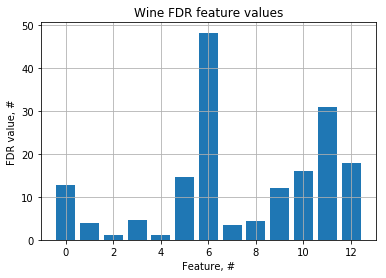

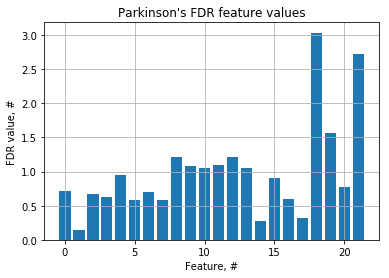

In [20]:
pylab.show()

In [22]:
sw, sb = scatter_matrix(X_wine, y_wine)
print("Wine datasets scatter criterion values: (J1, J2, J3): ", scatter_matrix_criterion(sw, sb))

Wine datasets scatter criterion values: (J1, J2, J3):  (1.0384001319944802, 1.2304121041955283, 0.21926069815839544)


In [23]:
sw, sb = scatter_matrix(X_pak, y_pak)
print ("Parkinson's datasets scatter criterion values: (J1, J2, J3): ", scatter_matrix_criterion(sw, sb))

Parkinson's datasets scatter criterion values: (J1, J2, J3):  (1.0008021689311137, 1.0210155747245215, 0.020868355561958023)


## Class Separability

In [24]:
# LDA PLOTS
pylab.figure()
X_lda = MDA().fit_transform(X_iris, y_iris)
for c, m,i, target_name in zip("rgb", ('^', 's', 'o'), [0, 1, 2], iris.target_names):
    pylab.scatter(X_lda[y_iris == i, 0], X_lda[y_iris == i, 1], c=c, marker=m, label=target_name)

pylab.grid('on')
pylab.legend()
pylab.xlabel('LD1')
pylab.ylabel('LD2')
pylab.title('LDA of IRIS dataset')
pylab.draw()

In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit(X_iris).transform(X_iris)

pylab.figure()
for c, m, i, target_name in zip("rgb", ('^', 's', 'o'), [0, 1, 2], iris.target_names):
    pylab.scatter(X_pca[y_iris == i, 0], X_pca[y_iris == i, 1], c=c, marker=m, label=target_name)

pylab.grid('on')
pylab.legend()
pylab.xlabel('PC1')
pylab.ylabel('PC2')
pylab.title('PCA of IRIS dataset')
pylab.draw()

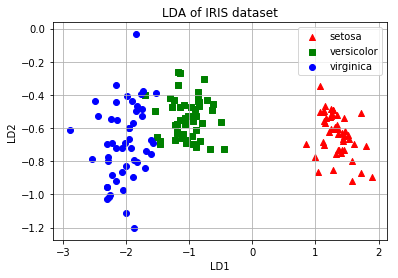

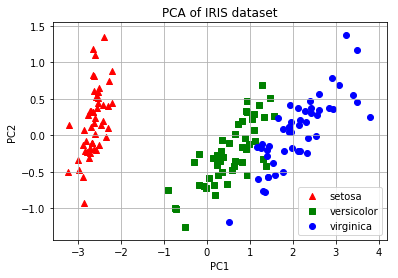

In [26]:
pylab.show()

## Classification perfomance

### With standardisation

In [28]:
normalise = StandardScaler()
classifier = KNeighborsClassifier(n_neighbors=15, algorithm='ball_tree')
lda = MDA(n_components=2)
classifier_lda_w = Pipeline(steps=[('normalise', normalise), ('lda', lda) , ('k-nn', classifier)])

print("LDA-2 Wine:", cross_val_score(classifier_lda_w, X=X_wine, y=y_wine, cv=10))

LDA-2 Wine: [0.94736842 0.94444444 1.         0.94444444 1.         0.94444444
 1.         1.         1.         1.        ]


In [29]:
classifier_without_w = Pipeline(steps=[('normalise', normalise), ('k-nn', classifier)])
print("Original wine:", cross_val_score(classifier_without_w, X=X_wine, y=y_wine, cv=10))

Original wine: [0.94736842 0.94444444 1.         0.94444444 1.         0.88888889
 1.         1.         0.9375     1.        ]


In [30]:
pca = PCA(n_components=2)
classifier_pca_w = Pipeline(steps=[('normalise', normalise), ('pca', pca) , ('k-nn', classifier)])
print("PCA-2 wine", cross_val_score(classifier_pca_w, X=X_wine, y=y_wine, cv=10))

PCA-2 wine [0.94736842 0.94444444 1.         0.94444444 1.         0.94444444
 0.94444444 1.         0.9375     1.        ]


### Without sdandardisation

In [33]:
classifier_lda_nw = Pipeline(steps=[('lda', lda) , ('k-nn', classifier)])
print("LDA-2 wine", cross_val_score(classifier_lda_nw, X=X_wine, y=y_wine, cv=10))

LDA-2 wine [0.94736842 0.94444444 1.         0.94444444 1.         0.94444444
 1.         1.         0.9375     1.        ]


In [23]:
classifier_pca_nw = Pipeline(steps=[('pca', pca), ('k-nn', classifier)])
print "PCA-2 wine", cross_val_score(classifier_pca_nw, X=X_wine, y=y_wine, cv=10).mean()

PCA-2 wine 0.712975146199


In [24]:
classifier_without_nw = Pipeline(steps=[('k-nn', classifier)])
print "Original wine", cross_val_score(classifier_without_nw, X=X_wine, y=y_wine, cv=10).mean()

Original wine 0.718530701754


##Conclusion


1. Normalise your data
2. Use LDA when FDR ratio bween your feature is significantly different
3. Choose your features well
4. LDA performs a form of data standardisation